# Распознавание эмоций человека
[Skillbox. Дипломная работа по компьютерному зрению](https://www.kaggle.com/c/skillbox-computer-vision-project/)

In [ ]:
# Структура папок

# BASE_PATH/
# ├─ dataset/                 # Содержит изображения
# │  ├─ test_kaggle/          # тестовые изображения
# │  └─ train/                # изображения для обучения
# │     ├─ {эмоция_1}/
# │     ├─ {эмоция_2}/
# │     └─ ...
# └─ zip/                     # Скачанные архивы
# └─ text_files/              # Всякие *.csv
# └─ exported_models/         # Готовые модели

In [ ]:
# Распаковываем данные. Нужно сделать 1 раз.
# !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/test_kaggle.zip -d /content/drive/MyDrive/hackathons/cv_emotions/dataset
# !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/train.zip -d /content/drive/MyDrive/hackathons/cv_emotions/dataset
# !unzip /content/drive/MyDrive/hackathons/cv_emotions/zip/train.csv.zip -d /content/drive/MyDrive/hackathons/cv_emotions/text_files

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import tensorflow as tf

In [ ]:
BASE_PATH = '/content/drive/MyDrive/hackathons/cv_emotions'
TRAIN_FOLDER = BASE_PATH + '/dataset/train'
EXP_MODELS = BASE_PATH + '/exported_models'

BATCH_SIZE = 50
IMG_SIZE = (250, 250)

Посмотрим на данные, которые у нас есть

# Изучение данных

In [ ]:
df_train = pd.read_csv(BASE_PATH + '/text_files/train.csv')
df_train = df_train[['image_path', 'emotion']]
df_train.head()

,image_path,emotion
0,./train/anger/0.jpg,anger
1,./train/anger/1.jpg,anger
2,./train/anger/10.jpg,anger
3,./train/anger/100.jpg,anger
4,./train/anger/1000.jpg,anger


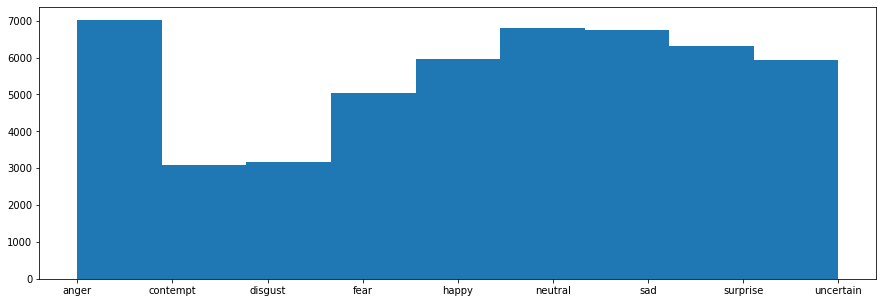

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(df_train.emotion,
         bins = len(df_train.emotion.unique()),
         align='mid')
plt.show()

In [ ]:
df_train_group = df_train[['emotion']].groupby(['emotion']).agg({'emotion':'count'}).rename(columns={'emotion':'img_number'}).reset_index()

In [ ]:
df_train_group['img_num_share'] = df_train_group['img_number']/df_train.shape[0]

In [ ]:
df_train_group

,emotion,img_number,img_num_share
0,anger,7022,0.140311
1,contempt,3085,0.061643
2,disgust,3155,0.063042
3,fear,5044,0.100787
4,happy,5955,0.118991
5,neutral,6795,0.135775
6,sad,6740,0.134676
7,surprise,6323,0.126344
8,uncertain,5927,0.118431


Мы видим, что меньше всего эмоций contempt и disgust — около 6 %. Остальные растпрелеоены от 11 до 14 %

In [ ]:
# Поскольку структура моих папок не совпадает со структурой, 
# предложенной в train.csv. Я переименую все в df

def change_folders(name):
  str_len = len(name)
  return BASE_PATH + '/dataset' + name[-str_len+1:]

In [ ]:
df_train['image_full_path'] = df_train['image_path'].apply(lambda x: change_folders(x))

Настало время изучить наши изображения с помощью методики пристального взгляда

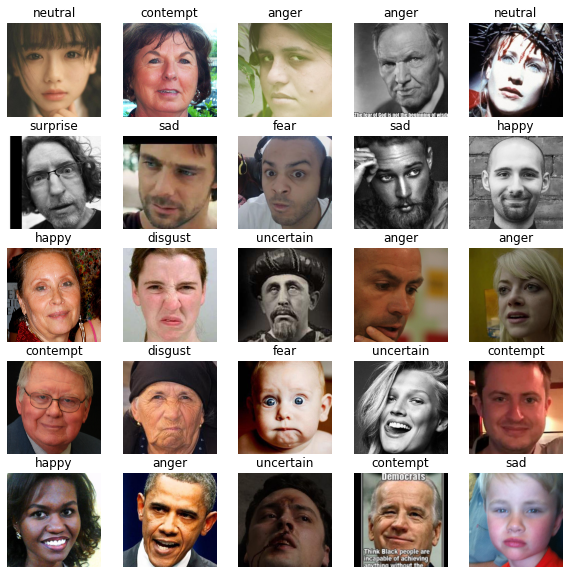

In [ ]:
# Просмотр изображений на трейне

plt.figure(figsize=(10,10))

for i in range(25):
  # Рандом целого числа от 0 до кол-ва строк в трейнк
  current_pic_row = random.randint(0, df_train.shape[0]) 
  img = Image.open(df_train.loc[current_pic_row, 'image_full_path'])
  title = df_train.loc[current_pic_row, 'emotion']

  plt.subplot(5,5,i+1).set_title(title)
  plt.imshow(img)
  plt.axis("off")

plt.show()

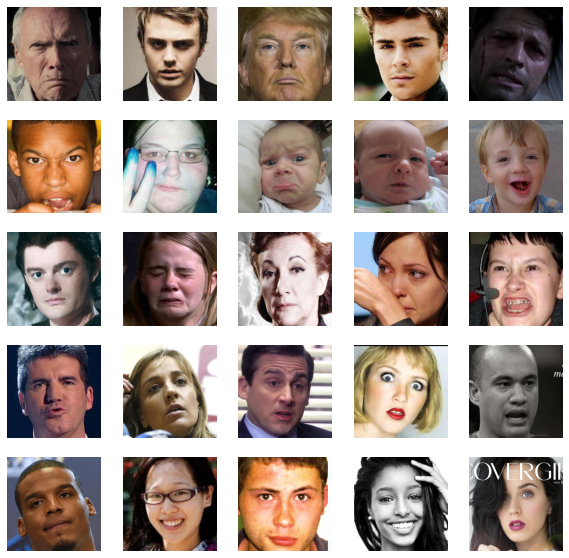

In [ ]:
# Просмотр изображений на тесте

# Получим список изображений из папки теста

all_test_images = os.listdir(BASE_PATH + '/dataset/test_kaggle')

plt.figure(figsize=(10,10))

for i in range(25):
  # Рандом целого числа от 0 до кол-ва строк в трейнк
  current_pic_row = random.randint(0, len(all_test_images)) 
  img = Image.open(BASE_PATH + '/dataset/test_kaggle//' + all_test_images[current_pic_row])

  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.axis("off")

plt.show()

In [ ]:
# Посмотрим на размер всех картинок
# Не сильно быстрая процедура (около 2 минут, поэтому я ее закомментирую)
# Пересохраню df_train, как df_train_updated и работать буду с ним.
# Если хотите повторить процедуру, нужно разкоментировать закоментированное
# и наоборот

# df_train['width'] = None
# df_train['height'] = None

# for i, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
#   img = Image.open(row['image_full_path'])
#   width, height = img.size
#   df_train.loc[i, 'width'] = width
#   df_train.loc[i, 'height'] = height

# df_train.to_csv(BASE_PATH + '/text_files/train_upd.csv')

df_train = pd.read_csv(BASE_PATH + '/text_files/train_upd.csv')
df_train.head()

,Unnamed: 0,image_path,emotion,image_full_path,width,height
0,0,./train/anger/0.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,183,183
1,1,./train/anger/1.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,749,749
2,2,./train/anger/10.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,261,261
3,3,./train/anger/100.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,234,234
4,4,./train/anger/1000.jpg,anger,/content/drive/MyDrive/hackathons/cv_emotions/...,299,299


In [ ]:
df_train.emotion.unique()

array(['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise', 'uncertain'], dtype=object)

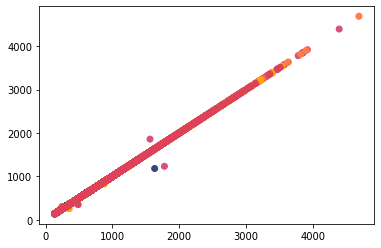

In [ ]:
fig, ax = plt.subplots()
colors = {'anger':'#003f5c',
          'contempt':'#2f4b7c',
          'disgust':'#665191',
          'fear':'#a05195',
          'happy':'#d45087',
          'neutral':'#f95d6a',
          'sad':'#ff7c43',
          'surprise':'#ffa600',
          'uncertain':'#de425b'
          }
ax.scatter(df_train['width'], df_train['height'], c=df_train['emotion'].map(colors))
plt.show()

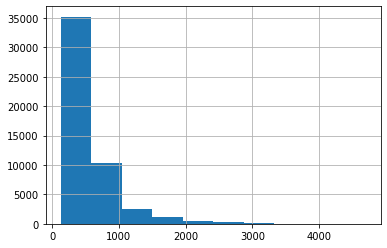

In [ ]:
df_train['width'].hist()

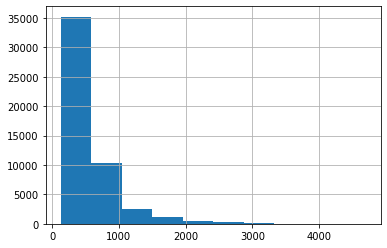

In [ ]:
df_train['height'].hist()

In [ ]:
df_train.describe()

,Unnamed: 0,width,height
count,50046.000000,50046.000000,50046.000000
mean,25022.500000,523.587939,523.595452
std,14447.180123,425.017862,424.975074
min,0.000000,133.000000,133.000000
25%,12511.250000,247.000000,247.000000
50%,25022.500000,371.000000,371.000000
75%,37533.750000,660.000000,660.000000
max,50045.000000,4689.000000,4689.000000


Основное распределение размеров - до 500×500 px. Так и запишем в гиперпараметрах IMG_SIZE

# Обучение

In [ ]:
# Разбиваем train на train и validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_FOLDER,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size = BATCH_SIZE,
  image_size = IMG_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_FOLDER,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size = BATCH_SIZE,
  image_size = IMG_SIZE)

Found 50046 files belonging to 9 classes.
Using 40037 files for training.
Found 50046 files belonging to 9 classes.
Using 10009 files for validation.


In [ ]:
# Список классов в правильном порядке. Нужно будет потом
class_names = train_ds.class_names
# class_names

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Добавляем слой аугментаций. Разрешаем горизонтально отражать и поворачивать до 20 градусов
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.20),
])

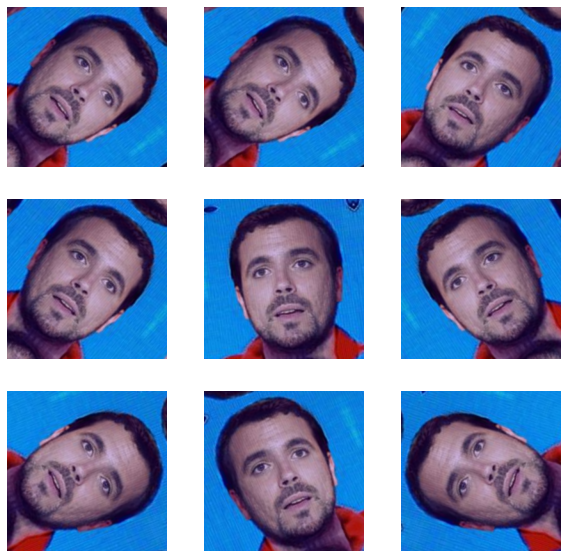

In [ ]:
# Посмотрим на аугментации
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Попробуем VGG16

In [ ]:
# Готовим изображение на вход
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Разделяем на картинки и лэйблы
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [ ]:
# Пока будем обучать только последний выходной слой
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
checkpoint_path = BASE_PATH + '/exported_models/vgg16_c.h5'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1, 
                                                 monitor='val_accuracy',
                                                 save_best_only=True)


In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
base_learning_rate = 0.0001
# Initiate model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
EPOCHS = 80

In [ ]:
# Меняем learning_rate, если нужно

# tf.keras.backend.set_value(
#     model.optimizer.learning_rate,
#     0.0001
# )

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/80
801/801 [==============================] - ETA: 0s - loss: 1.9541 - accuracy: 0.2830

# Файнтюнинг модели

Посмотрим сколько слоев в модели всего. Разморозим последние и будем менять веса последних слоев. Посмотрим, насколько нам добавит это точности в определения классов